#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional, Input, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# 예측 결과 시각화
def plot_model_result(y_val, pred) :

    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화


    plt.subplot(2,1,1)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()
    plt.figure(figsize = (20,12))

    plt.subplot(2,1,2)
    plt.plot(y_val - pred)
    plt.title('오차그래프')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [4]:
import pandas as pd
import numpy as np

import os
from tqdm import tqdm
import gdown

def download_file(file_id, save_path) :
    if os.path.exists(save_path) :
        print(f'{save_path} 파일이 이미 존재합니다.')
        return

    gdown.download(id=file_id, output=save_path, quiet=False)

def dataset_extract(file_name) :

    with zipfile.ZipFile(file_name, 'r') as zip_ref :
        file_list = zip_ref.namelist()

        if os.path.exists(f'./{file_name[:-4]}/') :
            print(f'데이터셋 폴더가 이미 존재합니다.')
            return

        else :
            for f in tqdm(file_list, desc='Extracting', unit='files') :
                zip_ref.extract(member=f, path=f'./{file_name[:-4]}/')

file_id = '1SXaNd_-VcbRovBsjphxJgIxymNHIYVDL'
download_file(file_id, 'train12_df.csv')
file_id = '1AtqtZALjdDAaGRewIBKQUi8etuLaM6W8'
download_file(file_id, 'test12_df.csv')

Downloading...
From: https://drive.google.com/uc?id=1SXaNd_-VcbRovBsjphxJgIxymNHIYVDL
To: /content/train12_df.csv
100%|██████████| 158k/158k [00:00<00:00, 67.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1AtqtZALjdDAaGRewIBKQUi8etuLaM6W8
To: /content/test12_df.csv
100%|██████████| 3.63k/3.63k [00:00<00:00, 9.95MB/s]


In [7]:
train12 = pd.read_csv('train12_df.csv')
test12 = pd.read_csv('test12_df.csv')
display(train12.head(3))
print(train12.shape)
display(test12.head(3))
print(test12.shape)

,Date,Qty,WTI_Price,CustomerCount,year,month,day,weekday,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_month,s_day,s_weekday,target
0,2014-01-04,14188.0,93.48,5341.0,2014,1,4,5,1,5309.0,8848.857143,2859.619599,2479.523258,2014.0,1.0,6.0,0.0,7614.0
1,2014-01-05,14490.0,93.30,5123.0,2014,1,5,6,1,302.0,10089.285714,3658.964784,741.749501,2014.0,1.0,7.0,1.0,7124.0
2,2014-01-06,7614.0,93.12,3917.0,2014,1,6,0,1,-6876.0,9672.714286,-724.764944,-1333.949342,2014.0,1.0,8.0,2.0,8683.0


(1149, 18)


,Date,Qty,WTI_Price,CustomerCount,year,month,day,weekday,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_month,s_day,s_weekday,target
0,2017-03-04,16590.0,53.33,5382.0,2017,3,4,5,0,5383.0,12216.250000,2859.619599,1514.130401,2017.0,3.0,6.0,0.0,8985.0
1,2017-03-05,18768.0,53.33,5423.0,2017,3,5,6,0,2178.0,13526.600000,3658.964784,1582.435216,2017.0,3.0,7.0,1.0,8678.0
2,2017-03-06,8985.0,53.19,3882.0,2017,3,6,0,0,-9783.0,12769.666667,-724.764944,-3059.901723,2017.0,3.0,8.0,2.0,8965.0


(26, 18)


- 데이터 전처리

In [8]:
# 사용할 컬럼만 남기기
train12_drop = train12.drop(['Date', 'year', 'month', 'day','weekday'], axis=1)
test12_drop =test12.drop(['Date', 'year', 'month', 'day','weekday'], axis=1)
# 가변수화
train12_dum = pd.get_dummies(train12_drop,columns=['s_month','s_weekday'],drop_first=True)
test12_dum = pd.get_dummies(test12_drop,columns=['s_month','s_weekday'],drop_first=True)
# test에 없는 컬럼 추가 해주기
print()
print(train12_dum.columns)
print(test12_dum.columns)
train_cols = train12_dum.columns
test_cols = test12_dum.columns

for train_col in train_cols:
    if train_col not in test_cols:
        print(f'create "{train_col}"')
        test12_dum[train_col] = False
# 컬럼 정렬
test12_dum = test12_dum[train_cols]

train12_dum['seasonal'] = train12_dum['seasonal'].shift(-2)
test12_dum['seasonal'] = test12_dum['seasonal'].shift(-2)
train12_dum = train12_dum.dropna()
test12_dum = test12_dum.dropna()
display(train12_dum.head(3))
display(test12_dum.head(3))



Index(['Qty', 'WTI_Price', 'CustomerCount', 'C_WTI_Price', 'Qty_change',
       'trend', 'seasonal', 'residual', 's_year', 's_day', 'target',
       's_month_2.0', 's_month_3.0', 's_month_4.0', 's_month_5.0',
       's_month_6.0', 's_month_7.0', 's_month_8.0', 's_month_9.0',
       's_month_10.0', 's_month_11.0', 's_month_12.0', 's_weekday_1.0',
       's_weekday_2.0', 's_weekday_3.0', 's_weekday_4.0', 's_weekday_5.0',
       's_weekday_6.0'],
      dtype='object')
Index(['Qty', 'WTI_Price', 'CustomerCount', 'C_WTI_Price', 'Qty_change',
       'trend', 'seasonal', 'residual', 's_year', 's_day', 'target',
       's_weekday_1.0', 's_weekday_2.0', 's_weekday_3.0', 's_weekday_4.0',
       's_weekday_5.0', 's_weekday_6.0'],
      dtype='object')
create "s_month_2.0"
create "s_month_3.0"
create "s_month_4.0"
create "s_month_5.0"
create "s_month_6.0"
create "s_month_7.0"
create "s_month_8.0"
create "s_month_9.0"
create "s_month_10.0"
create "s_month_11.0"
create "s_month_12.0"


,Qty,WTI_Price,CustomerCount,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_day,...,s_month_9.0,s_month_10.0,s_month_11.0,s_month_12.0,s_weekday_1.0,s_weekday_2.0,s_weekday_3.0,s_weekday_4.0,s_weekday_5.0,s_weekday_6.0
0,14188.0,93.48,5341.0,1,5309.0,8848.857143,-724.764944,2479.523258,2014.0,6.0,...,False,False,False,False,False,False,False,False,False,False
1,14490.0,93.30,5123.0,1,302.0,10089.285714,-1355.644528,741.749501,2014.0,7.0,...,False,False,False,False,True,False,False,False,False,False
2,7614.0,93.12,3917.0,1,-6876.0,9672.714286,-634.394710,-1333.949342,2014.0,8.0,...,False,False,False,False,False,True,False,False,False,False


,Qty,WTI_Price,CustomerCount,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_day,...,s_month_9.0,s_month_10.0,s_month_11.0,s_month_12.0,s_weekday_1.0,s_weekday_2.0,s_weekday_3.0,s_weekday_4.0,s_weekday_5.0,s_weekday_6.0
0,16590.0,53.33,5382.0,0,5383.0,12216.250000,-724.764944,1514.130401,2017.0,6.0,...,False,False,False,False,False,False,False,False,False,False
1,18768.0,53.33,5423.0,0,2178.0,13526.600000,-1355.644528,1582.435216,2017.0,7.0,...,False,False,False,False,True,False,False,False,False,False
2,8985.0,53.19,3882.0,0,-9783.0,12769.666667,-634.394710,-3059.901723,2017.0,8.0,...,False,False,False,False,False,True,False,False,False,False


In [9]:
# 데이터셋 나누기
X = train12_dum.drop('target',axis=1)
Y = train12_dum.loc[:,'target']
X_test = test12_dum.drop('target',axis=1)
Y_test = test12_dum.loc[:,'target']
# scale
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_cols = X.columns
X_test_cols = X_test.columns

X = scaler.fit_transform(X)
X = pd.DataFrame(X)
X.columns = X_cols

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)
X_test.columns = X_test_cols

y_max, y_min = Y.max(), Y.min()
Y = (Y-y_min)/(y_max-y_min)
Y_test = (Y_test-y_min)/(y_max-y_min)
print(Y.max(), Y.min())

display(X.head())
display(X_test.head())


1.0 0.0


,Qty,WTI_Price,CustomerCount,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_day,...,s_month_9.0,s_month_10.0,s_month_11.0,s_month_12.0,s_weekday_1.0,s_weekday_2.0,s_weekday_3.0,s_weekday_4.0,s_weekday_5.0,s_weekday_6.0
0,0.382364,0.823019,0.638952,1.0,0.588295,0.114444,0.305780,0.499524,0.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.390503,0.820817,0.612872,1.0,0.478540,0.204307,0.205872,0.452486,0.0,0.200000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.205196,0.818615,0.468597,1.0,0.321197,0.174129,0.320091,0.396301,0.0,0.233333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.191991,0.820939,0.438210,1.0,0.461179,0.154599,0.000000,0.407411,0.0,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.234005,0.803694,0.508913,1.0,0.506094,0.123924,0.238734,0.441548,0.0,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


,Qty,WTI_Price,CustomerCount,C_WTI_Price,Qty_change,trend,seasonal,residual,s_year,s_day,...,s_month_9.0,s_month_10.0,s_month_11.0,s_month_12.0,s_weekday_1.0,s_weekday_2.0,s_weekday_3.0,s_weekday_4.0,s_weekday_5.0,s_weekday_6.0
0,0.447098,0.331947,0.643857,0.0,0.589917,0.358397,0.305780,0.473392,1.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.505794,0.331947,0.648762,0.0,0.519662,0.453326,0.205872,0.475241,1.0,0.200000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.242144,0.330235,0.464410,0.0,0.257475,0.398490,0.320091,0.349583,1.0,0.233333,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.233871,0.323997,0.457950,0.0,0.465191,0.356143,0.000000,0.374172,1.0,0.266667,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.241605,0.289139,0.491805,0.0,0.478211,0.331905,0.238734,0.371474,1.0,0.300000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


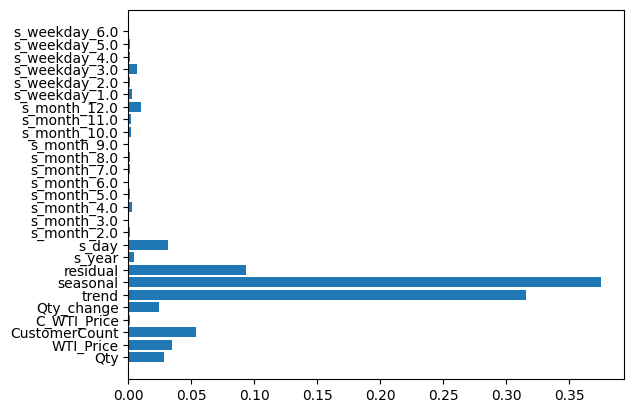

In [10]:
# feature 선택
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(max_depth=20)

rf_model.fit(X, Y)

plt.barh(list(X), width=rf_model.feature_importances_)
plt.show()


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [11]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [15]:
from sklearn.model_selection import train_test_split
x, y = temporalize(X, Y, 7)
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=60, shuffle=False)
X_test_3, Y_test_3 = temporalize(X_test, Y_test, 7)


In [13]:
x_train.shape

(1081, 7, 27)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 64)             8704      
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 32)             10272     
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 16)             2576      
                                                                 
 flatten (Flatten)           (None, 112)               0         
                                                                 
 dropout (Dropout)           (None, 112)               0         
                                                                 
 dense (Dense)               (None, 64)                7232      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

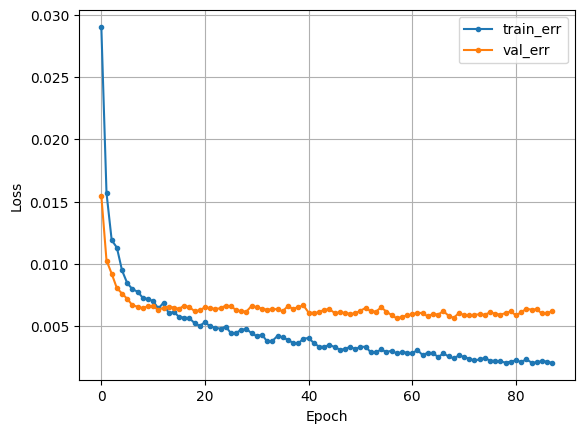

validation
2/2 [==============================] - 0s 7ms/step


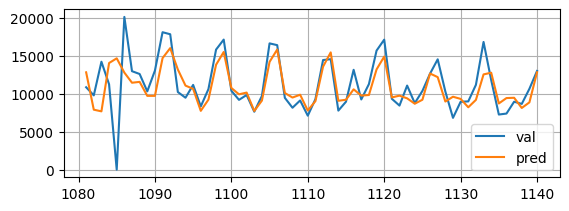

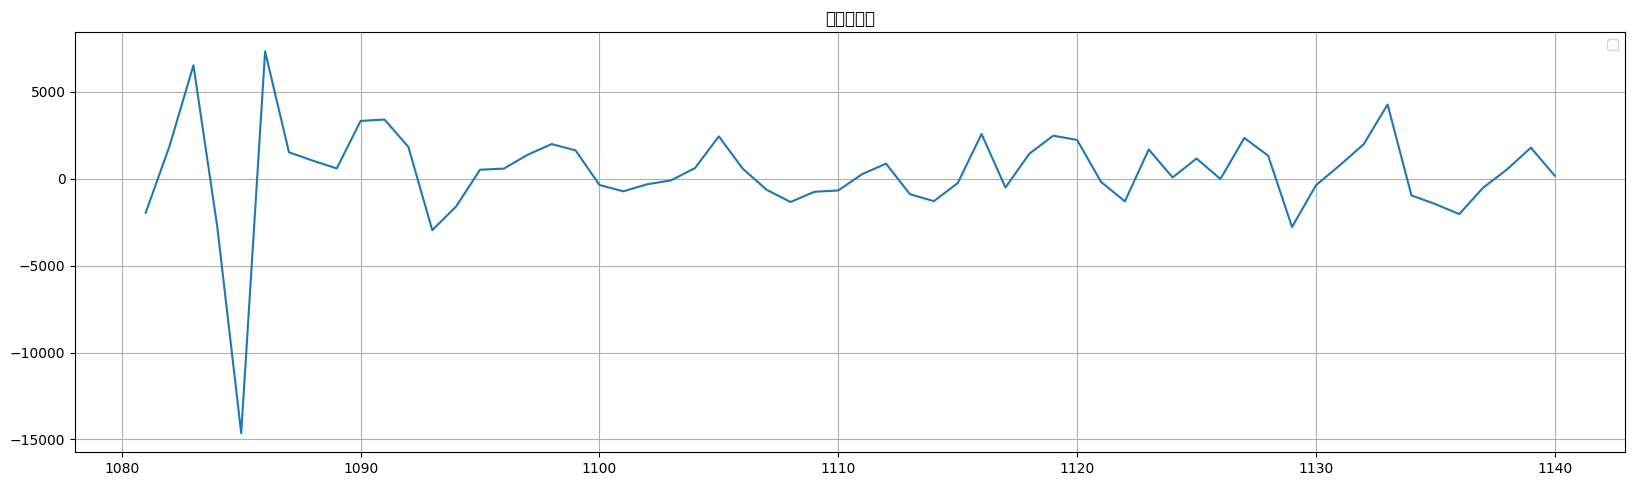

2782.281949432935
1741.710066731771
1.0987140420412113e+18
0.37053332371368275
--------------------------------------------------------------------------------
test
1/1 [==============================] - 0s 21ms/step


NameError: name 'Y_test_3' is not defined

In [14]:
c_model = Sequential()
c_model.add(Input(shape=(7,27)))
c_model.add(Conv1D(64, 5, activation='relu', padding = 'same'))
c_model.add(Conv1D(32, 5, activation='relu', padding = 'same'))
c_model.add(Conv1D(16, 5, activation='relu', padding = 'same'))
c_model.add(Flatten())
c_model.add(Dropout(0.2))
c_model.add(Dense(64,activation='relu'))
c_model.add(Dropout(0.2))
c_model.add(Dense(1))

c_model.summary()


c_model.compile(loss='mse', optimizer=Adam(0.0001), metrics=['mae'])
es = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
history = c_model.fit(x_train.astype(float),y_train, validation_data=(x_val.astype(float),y_val), epochs=500, callbacks=[es]).history

dl_history_plot(history)

print('validation')
pred = c_model.predict(x_val)
pred = pred*(y_max-y_min) + y_min
y_val_decode = y_val*(y_max-y_min) + y_min

plot_model_result(y_val_decode, pred)

print((mean_squared_error(y_val_decode,pred))**0.5)
print(mean_absolute_error(y_val_decode,pred))
print(mean_absolute_percentage_error(y_val_decode,pred))
print(r2_score(y_val_decode,pred))
print('-'*80)

print('test')
pred = c_model.predict(X_test_3)
pred = pred*(y_max-y_min) + y_min
Y_test_decode = Y_test_3*(y_max-y_min) + y_min

plot_model_result(Y_test_decode, pred)

print((mean_squared_error(Y_test_decode,pred))**0.5)
print(mean_absolute_error(Y_test_decode,pred))
print(mean_absolute_percentage_error(Y_test_decode,pred))
print(r2_score(Y_test_decode,pred))

validation
2/2 [==============================] - 0s 9ms/step


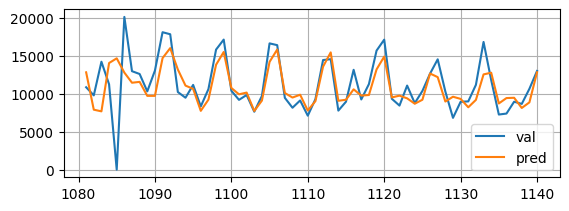

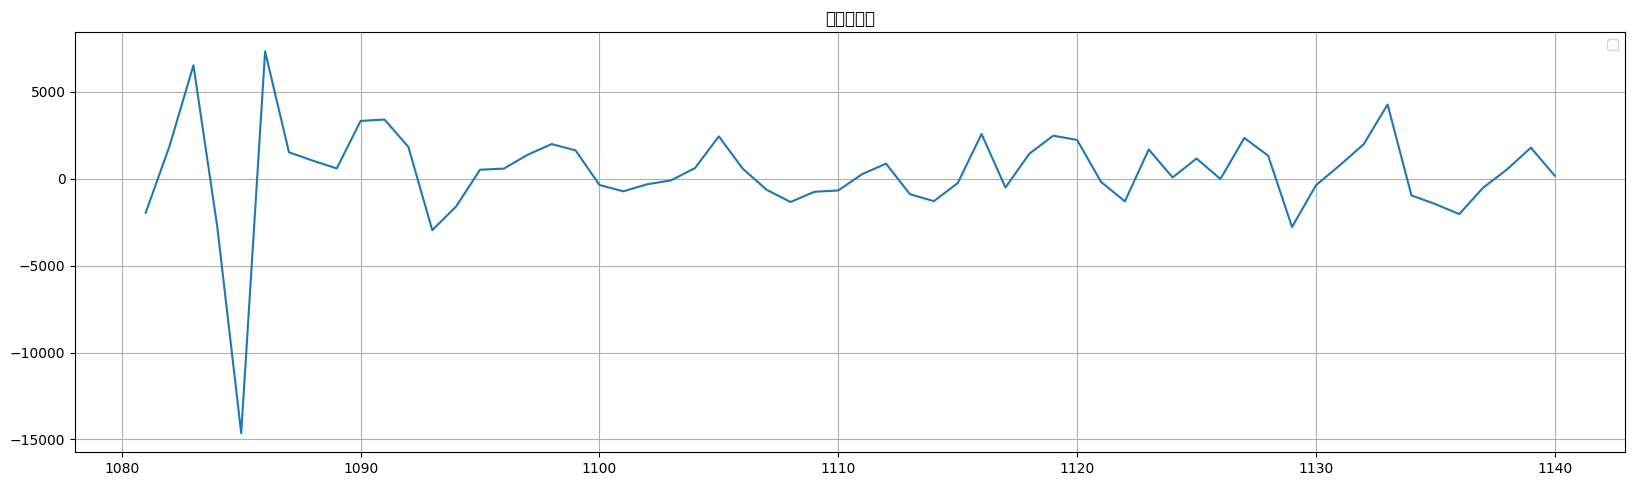

2782.281949432935
1741.710066731771
1.0987140420412113e+18
0.37053332371368275
--------------------------------------------------------------------------------
test
1/1 [==============================] - 0s 21ms/step


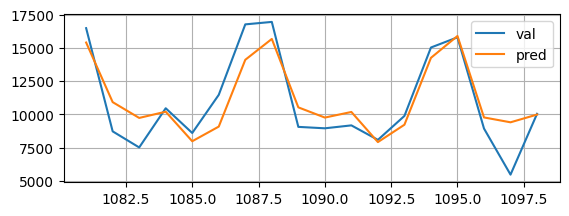

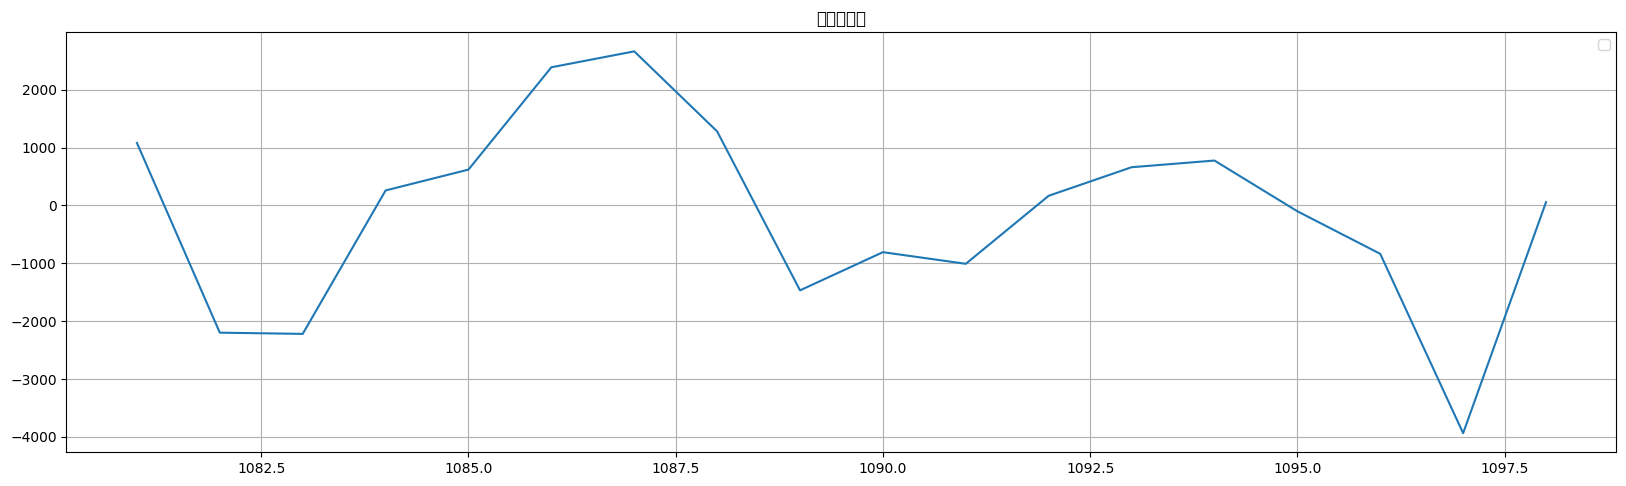

1614.812857463312
1251.885986328125
0.1379157905407018
0.785259050235114


In [16]:
print('validation')
pred = c_model.predict(x_val)
pred = pred*(y_max-y_min) + y_min
y_val_decode = y_val*(y_max-y_min) + y_min

plot_model_result(y_val_decode, pred)

print((mean_squared_error(y_val_decode,pred))**0.5)
print(mean_absolute_error(y_val_decode,pred))
print(mean_absolute_percentage_error(y_val_decode,pred))
print(r2_score(y_val_decode,pred))
print('-'*80)

print('test')
pred = c_model.predict(X_test_3)
pred = pred*(y_max-y_min) + y_min
Y_test_decode = Y_test_3*(y_max-y_min) + y_min

plot_model_result(Y_test_decode, pred)

print((mean_squared_error(Y_test_decode,pred))**0.5)
print(mean_absolute_error(Y_test_decode,pred))
print(mean_absolute_percentage_error(Y_test_decode,pred))
print(r2_score(Y_test_decode,pred))

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

##### 상품 : 12

In [ ]:
def pipeline(oil_price,orders,sales,products,stores,train,scaler,y_max,y_min):
    # sales, oil_price merge
    df = pd.merge(sales, oil_price, on=['Date'], how='left')
    # df, orders merge
    df = pd.merge(df, orders, on=['Date', 'Store_ID'], how='left')
    # df, products merge
    df = pd.merge(df, products, on=['Product_ID'], how='left')
    # df, stores merge
    df = pd.merge(df, stores, on=['Store_ID'], how='left')

    # 44매장 12번 상품
    df_12 = df.loc[(df['Store_ID']==44)&(df['Product_ID']==12),:]

    # 결측치 처리
    df_12['WTI_Price'] = df_12['WTI_Price'].fillna(method='ffill')

    # 파생변수
    # 날짜 데이터
    df_12['year'] = df_12['Date'].dt.year
    df_12['month'] = df_12['Date'].dt.month
    df_12['day'] = df_12['Date'].dt.day
    df_12['weekday'] = df_12['Date'].dt.weekday

    # WTI_Price 범주형 추가
    df_12['C_WTI_Price'] = 0
    df_12.loc[df_12['WTI_Price']>73,'C_WTI_Price'] = 1

    # Qty 변화량
    df_12['Qty_change'] = df_12['Qty'] - df_12['Qty'].shift(1)


    # trend
    df_12['trend']=df_12['Qty'].rolling(window=7,min_periods=4).mean()
    # seasonal
    seasonal = train.loc[2:8,['weekday','seasonal']]
    seasonal = seasonal.sort_values(by='weekday')
    seasonal = list(seasonal['seasonal'].values.reshape(-1))
    df_12['seasonal'] = 0
    for i in range(7):
        df_12.loc[df_12.weekday==i,'seasonal'] = seasonal[i]
    # residual
    df_12['residual'] = df_12['Qty'] - df_12['trend'] - df_12['seasonal']


    # shift(-2) ['year', 'month', 'day', 'weekday']
    df_12['s_year'] = df_12['year'].shift(-2)
    df_12['s_month'] = df_12['month'].shift(-2)
    df_12['s_day'] = df_12['day'].shift(-2)
    df_12['s_weekday'] = df_12.loc[:,'weekday'].shift(-2)
    df_12['target'] = df_12['Qty'].shift(-2)


    test12_df = df_12[['Date', 'Qty', 'WTI_Price', 'CustomerCount', 'year', 'month', 'day', 'weekday', 'C_WTI_Price',
       'Qty_change', 'trend', 'seasonal', 'residual', 's_year', 's_month',
       's_day', 's_weekday','target']].dropna().reset_index(drop=True)
    # 사용할 컬럼만 남기기
    test12_drop = test12_df.drop(['Date', 'year', 'month', 'day','weekday'], axis=1)
    # 가변수화
    test12_dum = pd.get_dummies(test12_drop,columns=['s_month','s_weekday'],drop_first=True)
    # test에 없는 컬럼 추가 해주기
    train_cols = ['Qty', 'WTI_Price', 'CustomerCount', 'C_WTI_Price', 'Qty_change',
       'trend', 'seasonal', 'residual', 's_year', 's_day', 'target',
       's_month_2.0', 's_month_3.0', 's_month_4.0', 's_month_5.0',
       's_month_6.0', 's_month_7.0', 's_month_8.0', 's_month_9.0',
       's_month_10.0', 's_month_11.0', 's_month_12.0', 's_weekday_1.0',
       's_weekday_2.0', 's_weekday_3.0', 's_weekday_4.0', 's_weekday_5.0',
       's_weekday_6.0']
    test_cols = test12_dum.columns

    for train_col in train_cols:
        if train_col not in test_cols:
            test12_dum[train_col] = False
    # 컬럼 정렬
    test12_dum = test12_dum[train_cols]

    # x_test, y_test 생성 및 scaling
    x_test = test12_dum.drop('target',axis=1)
    x_test_cols = x_test.columns
    x_test = scaler.transform(x_test)
    x_test = pd.DataFrame(x_test)
    x_test.columns = x_test_cols

    y_test = test12_dum.loc[:,'target']
    y_test = (y_test-y_min)/(y_max-y_min)


    return x_test,y_test


## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
import os
import zipfile
from tqdm import tqdm
import gdown

file_id = '1VI2j8lCkGwV0qmB36jWT-1P0gYnKfCJh'
download_file(file_id, 'test.zip')

dataset_extract('test.zip')

test.zip 파일이 이미 존재합니다.
데이터셋 폴더가 이미 존재합니다.


In [ ]:
path = './'
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

##### 상품 : 12

In [ ]:
x_test_p, y_test_p = pipeline(oil_price_test,orders_test,sales_test,products,stores,train12,scaler,y_max,y_min)

In [ ]:
train12_dum.columns

Index(['Qty', 'WTI_Price', 'CustomerCount', 'C_WTI_Price', 'Qty_change',
       'trend', 'seasonal', 'residual', 's_year', 's_day', 'target',
       's_month_2.0', 's_month_3.0', 's_month_4.0', 's_month_5.0',
       's_month_6.0', 's_month_7.0', 's_month_8.0', 's_month_9.0',
       's_month_10.0', 's_month_11.0', 's_month_12.0', 's_weekday_1.0',
       's_weekday_2.0', 's_weekday_3.0', 's_weekday_4.0', 's_weekday_5.0',
       's_weekday_6.0'],
      dtype='object')

#### * 예측해보기

##### 상품 : 12

# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


##### (1) 상품:3

In [ ]:
inv_simulator(y_test_org, y_3_1_tpred, 7590, 8)

일평균 재고량     : 13476.667
일평균 재고 금액  : 107813.336
일평균 재고회전율 : 0.942
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,8816.0,8842.0,16406,7590,15782,8816,0.0
1,10087.0,10417.0,17677,7590,16445,10087,0.0
2,15131.0,15782.0,23372,8241,8771,15782,0.0
3,18556.0,16445.0,24686,6130,9875,16445,0.0
4,8803.0,9422.0,14901,6098,10208,8771,0.0
5,8690.0,8415.0,15973,7283,9024,9875,0.0
6,9199.0,8716.0,17491,8292,9815,10208,0.0
7,8148.0,8717.0,17316,9168,14174,9024,0.0
8,11616.0,10517.0,18983,7367,16905,9815,0.0
9,16510.0,15752.0,21541,5031,12106,14174,0.0


##### (2) 상품:12

In [ ]:
x_test_p, y_test_p = pipeline(oil_price_test,orders_test,sales_test,products,stores,train12,scaler,y_max,y_min)

x_test_p, y_test_p = temporalize(x_test_p, y_test_p, 7)

pred = c_model.predict(x_test_p)
pred = pred*(y_max-y_min) + y_min
y_test_p_decode = y_test_p*(y_max-y_min) + y_min

inv_simulator(y_test_p_decode, pred, 2830, 6)

1/1 [==============================] - 0s 46ms/step
일평균 재고량     : 8336.278
일평균 재고 금액  : 50017.668000000005
일평균 재고회전율 : 1.354
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,16478.0,15811.0,19308,2830,6657,16478,0.0
1,8715.0,10644.0,11545,2830,9543,8715,0.0
2,7505.0,6657.0,9487,1982,7991,6657,0.0
3,10453.0,9543.0,11525,1072,11577,9543,0.0
4,8592.0,7143.0,9063,471,16337,7991,0.0
5,11463.0,9819.0,12048,585,16789,11577,0.0
6,16763.0,13978.0,16922,159,13259,16337,0.0
7,16948.0,14544.0,16948,0,10008,16789,0.0
8,9052.0,10588.0,13259,4207,8497,13259,0.0
9,8945.0,7178.0,14215,5270,6447,10008,0.0


In [ ]:
x_test_p.shape

(26, 27)

###### (3) 상품 : 42

In [ ]:
inv_simulator(y_test2, pred, 278, 5)

일평균 재고량     : 241.714
일평균 재고 금액  : 1208.57
일평균 재고회전율 : 0.638
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,110.0,0.0,388,278,0,110,0.0
1,101.0,0.0,379,278,0,101,0.0
2,131.0,0.0,278,147,131,0,0.0
3,145.0,0.0,147,2,276,0,0.0
4,90.0,-0.0,133,43,235,131,0.0
5,110.0,-0.0,319,209,69,276,0.0
6,107.0,0.0,444,337,0,235,0.0
7,108.0,0.0,406,298,0,69,0.0
8,136.0,0.0,298,162,116,0,0.0
9,119.0,0.0,162,43,235,0,0.0
